# CS-6476 Assignment 5: Generative Adversarial Networks

## Aim

To implement and train a simple generative-discriminative network on the MNIST dataset and generate novel images.

## Learning objectives

* Building custom dataset and dataloader.
* Understand the generator-discriminator network.
* Implement training loop for generative adversarial network. (GAN)
* Train and evaluate GAN on MNIST dataset.

## Grading schema

The assignment will be graded out of 16:

* Generator: 4 points
* Discriminator: 2 points
* End-to-end working: 2 points
* Write-up: 8 points


### Google colab setup
First, run the following cell to load the "autoreload" extension. The "autoreload" extension allows you to automatically reload (re-import) Python modules that you've imported or defined when they change. This is particularly useful when you are actively developing or modifying code in external modules and want those changes to be automatically reflected in your notebook without manually restarting the kernel.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import os
import sys

In [4]:
%cd drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 5
%ls

/content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 5
assn5_instructions.pdf  gan.py                                 ls_gan_results.jpg  __pycache__/
fc_gan_results.jpg      generative_adversarial_networks.ipynb  MNIST_data/         requirements.txt


In [5]:
#after running this block you should see files from the assignment folder
HOME = os.getcwd()
print(os.listdir(HOME))
sys.path.append(HOME)


['assn5_instructions.pdf', 'requirements.txt', 'MNIST_data', '__pycache__', 'fc_gan_results.jpg', 'gan.py', 'ls_gan_results.jpg', 'generative_adversarial_networks.ipynb']


# Generative Adversarial Networks (GANs)

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__.
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).

We will be tasked with implementation of vanilla GANs and vanilla GANs with least-squared loss.

Here's an example of what your output (left Vanilla GAN, right LS GAN) you're going to train should look like... note that GANs are sometimes finicky, so your output might not look exactly like this... this is just meant to be a *rough* guideline of the kind of quality you can expect:

![caption](https://github.com/divyanshj16/GANs/raw/master/images/tf/download.png)
![caption](https://github.com/divyanshj16/GANs/raw/master/images/tf/ls.png)

In [6]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import math
import os
import shutil
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch import nn
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

 Now we'll provide some helper functions to help us visualize the MNIST dataset, verify the neural networks you implement, and initialize weights in the `torch.nn` modules you'll write.

In [7]:
def show_images(images):
    images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def count_params(model):
    """Count the number of parameters in the model"""
    param_count = sum([p.numel() for p in model.parameters()])
    return param_count

def initialize_weights(m):
  """ Initializes the weights of a torch.nn model using xavier initialization"""
  if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
    nn.init.xavier_uniform_(m.weight.data)

def rel_error(x, y, eps=1e-10):
    """
    Compute the relative error between a pair of tensors x and y,
    which is defined as:

                            max_i |x_i - y_i]|
    rel_error(x, y) = -------------------------------
                      max_i |x_i| + max_i |y_i| + eps

    Inputs:
    - x, y: Tensors of the same shape
    - eps: Small positive constant for numeric stability

    Returns:
    - rel_error: Scalar giving the relative error between x and y
    """
    """ returns relative error between x and y """
    top = (x - y).abs().max().item()
    bot = (x.abs() + y.abs()).clamp(min=eps).max().item()
    return top / bot

def reset_seed(number):
  """
  Reset random seed to the specific number

  Inputs:
  - number: A seed number to use
  """
  random.seed(number)
  torch.manual_seed(number)
  return

dtype = torch.float
device = 'cpu'
answers = {}

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`.

In [8]:
batch_size = 128
NOISE_DIM = 96

print('download MNIST if not exist')

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


download MNIST if not exist


## Random Noise
The first step is to generate uniform noise from -1 to 1 with shape `[batch_size, noise_dim]`

Hint: use `torch.rand`.

Implement `sample_noise` and verify all tests pass below

In [9]:
from gan import sample_noise
reset_seed(0)


batch_size = 3
noise_dim = 4

z = sample_noise(batch_size, noise_dim)
assert z.shape == (batch_size, noise_dim)
assert torch.is_tensor(z)
assert torch.all(z >= -1.0) and torch.all(z <= 1.0)
assert torch.any(z < 0.0) and torch.any(z > 0.0)
print('All tests passed!')

All tests passed!


# Discriminator
Our first step is to build a discriminator. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1

Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.

The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

Implement `discriminator` in `gan.py` and test your solution by running the cell below. Be sure to use `nn.Sequential` for this model definition and all future models in this notebook.

In [10]:
from gan import discriminator

def test_discriminator(true_count=267009):
  model = discriminator()
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in discriminator. Check your achitecture.')
  else:
    print('Correct number of parameters in discriminator.')

test_discriminator()

267009
Correct number of parameters in discriminator.


# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

Implement `generator` in `gan.py` and test your solution by running the cell below.

In [11]:
from gan import generator

def test_generator(true_count=1858320):
  model = generator(4)
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in generator. Check your achitecture.')
  else:
    print('Correct number of parameters in generator.')

test_generator()

1858320
Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

For the purpose of these equations, we assume that the output from the discriminator is a real number in the range $0 < D(x) < 1$ which results from squashing the raw score from the discriminator through a sigmoid function. However for a cleaner and more numerically stable implementation, we have not included the sigmoid in the discriminator architecture above -- instead we will implement the sigmoid as part of the loss function.

**HINTS**: You can use the function [`torch.nn.functional.binary_cross_entropy_with_logits`](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy-with-logits) to compute these losses in a numerically stable manner.

Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss (with logits) is defined as:

$$ bce(s, y) = -y * \log(\sigma(s)) - (1 - y) * \log(1 - \sigma(s)) $$

where $\sigma(s)=1/(1+\exp(-s))$ is the sigmoid function.

A naive implementation of this formula can be numerically unstable, so you should prefer to use the built-in PyTorch implementation.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:

`true_labels = torch.ones(size, device=device)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

Implement `discriminator_loss` and `generator_loss` in `gan.py` and test your solution by running the cell below.. You should see errors < `1e-7`.

In [12]:
from gan import discriminator_loss

answers['logits_fake'] = torch.tensor(
  [-1.80865868,  0.09030055, -0.4428902 , -0.07879368, -0.37655044,
    0.32084742, -0.28590837,  1.01376281,  0.99241439,  0.39394346],
  dtype=dtype, device=device)
answers['d_loss_true'] = torch.tensor(1.8423983904443109, dtype=dtype, device=device)
answers['logits_real'] = torch.tensor(
  [ 0.93487311, -1.01698916, -0.57304769, -0.88162704, -1.40129389,
   -1.45395693, -1.54239755, -0.57273325,  0.98584429,  0.13312152],
  dtype=dtype, device=device)

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
  d_loss = discriminator_loss(logits_real, logits_fake)
  print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 3.23517e-08


In [13]:
from gan import generator_loss

answers['g_loss_true'] = torch.tensor(0.771286196423346, dtype=dtype, device=device)

def test_generator_loss(logits_fake, g_loss_true):
  g_loss = generator_loss(logits_fake)
  print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 0


# Optimizing our loss


Next, you'll define a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. We'll use this to construct optimizers for the generators and discriminators for the rest of the notebook in `get_optimizer`.

Implement `get_optimizer` in `gan.py` before moving forward in the notebook

# Training a GAN!

Write the code to train your GAN. This will not be a part of your submission but you will have to utilise your output and findings as part of your analysis. Try to plot loss curve to make it a part of your analysis.

To implement a single training step for a GAN, follow the following steps:
1. Sample a batch of real images from the train dataloader, and a batch of fake images from the generator.
2. Pass them through the discriminator and calculate the loss over discriminator logits.
3. Backpropogate discriminator loss and update discriminator parameters.
4. Sample images from generator, pass them through discriminator and get fake images logits.
5. Calculate generator loss and backpropogate it. Perform update step for the generator.

The key here is to identify the trainable and non-trainable parts of the system when performing each of the above steps. Use `.detach()` wisely.

In [14]:
SAVEPATH = "./"

def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, save_filename="images.jpg", show_every=250,
              batch_size=128, noise_size=96, num_epochs=10):
  """
  Train a GAN!

  Inputs:
  - D, G: PyTorch models for the discriminator and generator
  - D_solver, G_solver: torch.optim Optimizers to use for training the
    discriminator and generator.
  - discriminator_loss, generator_loss: Functions to use for computing the generator and
    discriminator loss, respectively.
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - noise_size: Dimension of the noise to use as input to the generator.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in loader_train:
      if len(x) != batch_size:
        continue

      d_total_error = None
      g_error = None

      fake_images = None

      ############ START YOUR CODE HERE
      # 1) X is real training data from dataloader, get fake data from generator
      # Create tensor of size noise_dim and reshape
      real_images = x

      gen_noise = sample_noise(batch_size, noise_size)
      fake_images = G(gen_noise).detach()

      # 2) Pass through discriminator
      real_logits = D(real_images.view(-1,784))
      fake_logits = D(fake_images.view(-1,784))

      # 3) Calculate Loss, update params
      D_solver.zero_grad()
      d_total_error = discriminator_loss(real_logits, fake_logits)
      d_total_error.backward()
      D_solver.step()

      # 4) Sample more images from generator

      gen_noise = sample_noise(batch_size, noise_size)
      fake_images = G(gen_noise)
      fake_logits = D(fake_images.view(-1,784))

      # 5) Calculate loss, update params

      G_solver.zero_grad()
      g_error = generator_loss(fake_logits)
      g_error.backward()
      G_solver.step()

      #print("D Accuracy = ", )

      ############ END YOUR CODE HERE

      if (iter_count % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
        imgs_numpy = fake_images.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()
        print()
      iter_count += 1
    if epoch == num_epochs - 1:
      show_images(imgs_numpy[0:16])
      plt.savefig(os.path.join(SAVEPATH ,save_filename))

Now run the cell below to train your first GAN! Your last epoch results will be stored in `fc_gan_results.jpg` for you to submit to the autograder

Iter: 0, D: 1.385, G:0.6898


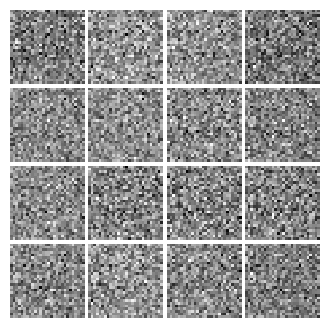


Iter: 250, D: 0.88, G:1.624


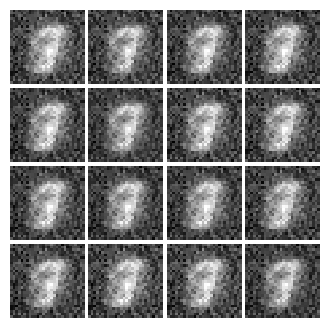


Iter: 500, D: 0.8018, G:2.459


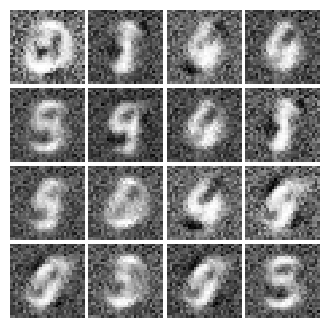


Iter: 750, D: 1.041, G:1.987


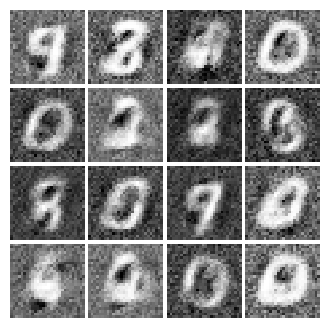


Iter: 1000, D: 1.002, G:1.932


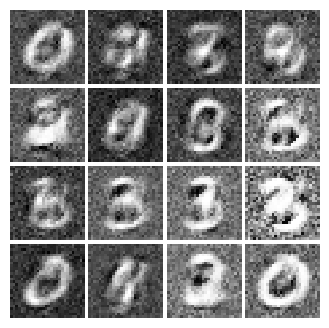


Iter: 1250, D: 1.037, G:2.335


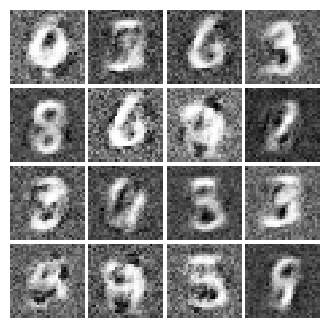


Iter: 1500, D: 0.8786, G:1.849


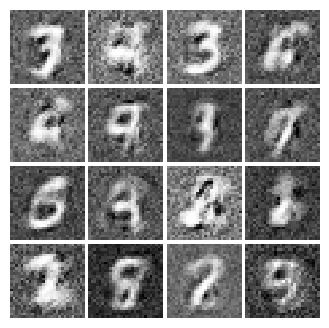


Iter: 1750, D: 0.9573, G:1.522


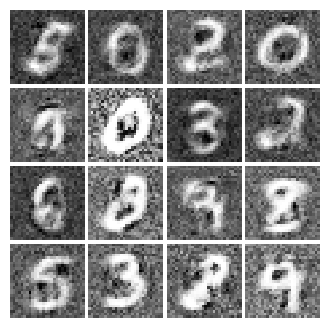


Iter: 2000, D: 0.981, G:1.974


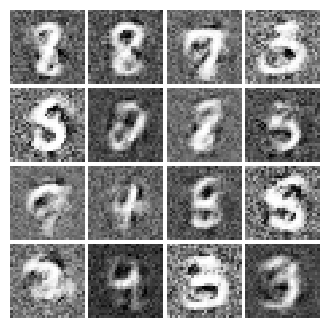


Iter: 2250, D: 1.08, G:1.272


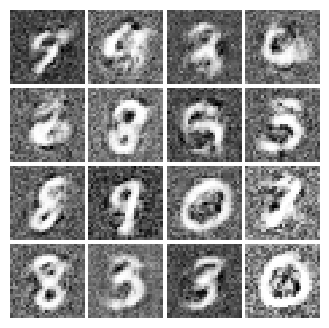


Iter: 2500, D: 0.6783, G:2.191


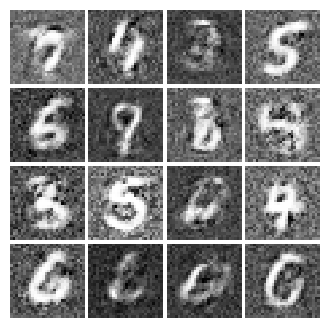


Iter: 2750, D: 0.692, G:2.019


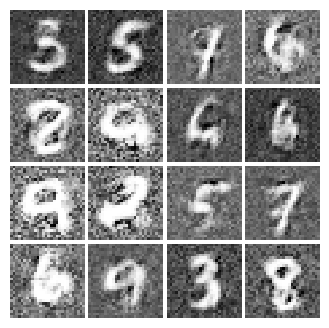


Iter: 3000, D: 0.7629, G:3.026


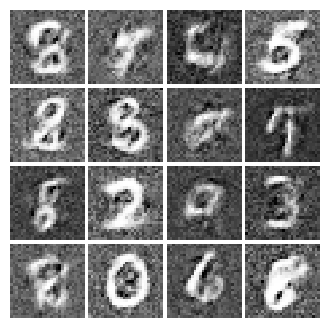


Iter: 3250, D: 0.6901, G:2.32


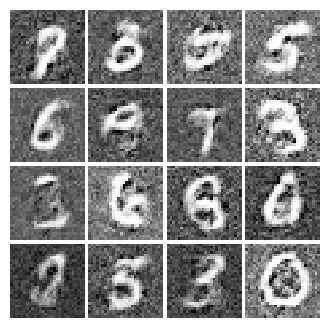


Iter: 3500, D: 0.7806, G:2.259


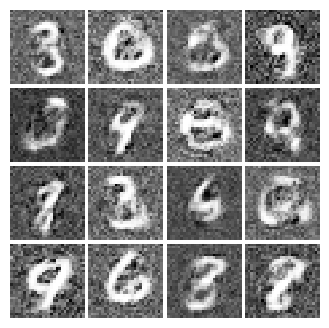


Iter: 3750, D: 0.6684, G:2.281


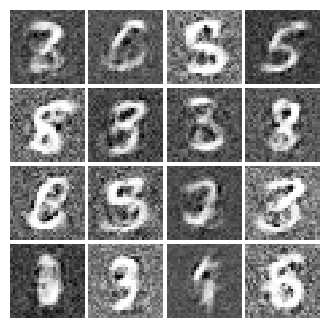


Iter: 4000, D: 0.7141, G:2.565


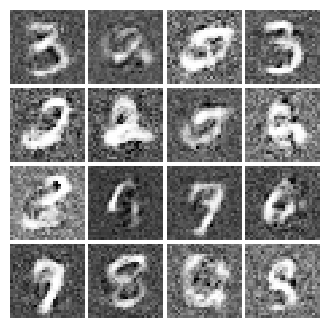


Iter: 4250, D: 0.6018, G:2.616


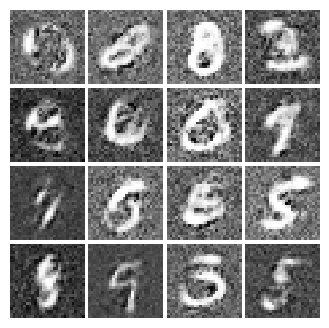


Iter: 4500, D: 0.6466, G:2.165


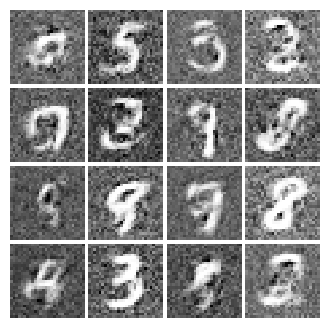

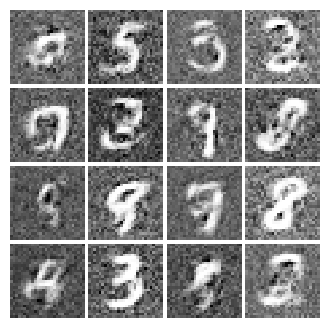

In [15]:
from gan import get_optimizer
reset_seed(0)

# Make the discriminator
D = discriminator().to(device)

# Make the generator
G = generator().to(device)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, 'fc_gan_results.jpg')

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$

and the discriminator loss:

$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In these equations, we assume that the output from the discriminator is an unbounded real number $-\infty < D(x) < \infty$.


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

Verify your implementation below, you should see relative errors of < `1e-7` or less

In [16]:
from gan import ls_discriminator_loss
from gan import ls_generator_loss

answers['d_loss_lsgan_true'] = torch.tensor(1.8770293614440594, dtype=dtype, device=device)
answers['g_loss_lsgan_true'] = torch.tensor(0.816954786997558, dtype=dtype, device=device)
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
  d_loss = ls_discriminator_loss(score_real, score_fake)
  g_loss = ls_generator_loss(score_fake)
  print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
  print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 3.64798e-08


Run the following cell to train your model! Your last epoch results will be stored in `ls_gan_results.jpg` for you to use for the write-up.

Iter: 0, D: 0.4693, G:0.4632


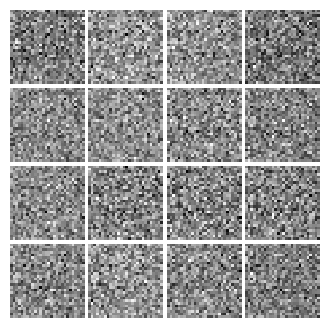


Iter: 250, D: 0.09756, G:0.646


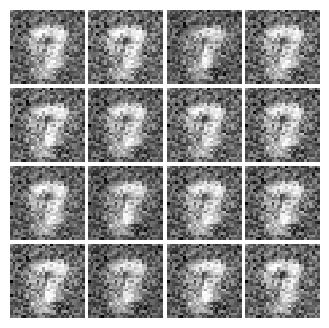


Iter: 500, D: 0.1024, G:0.5903


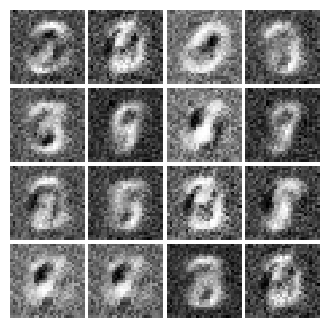


Iter: 750, D: 0.1182, G:0.501


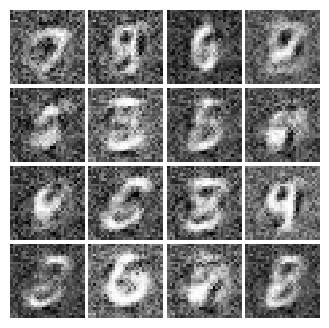


Iter: 1000, D: 0.1351, G:0.3872


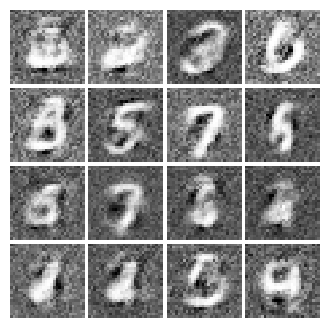


Iter: 1250, D: 0.1484, G:0.5778


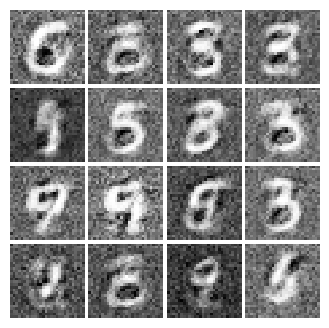


Iter: 1500, D: 0.1184, G:0.3646


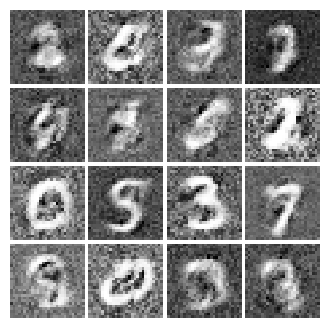


Iter: 1750, D: 0.1567, G:0.4733


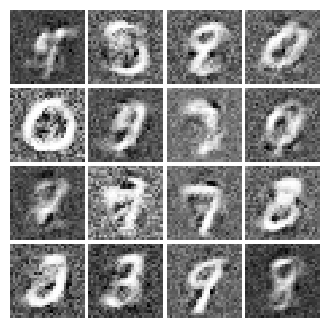


Iter: 2000, D: 0.1026, G:0.4012


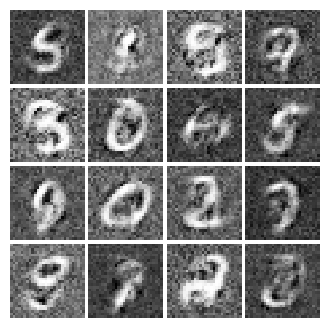


Iter: 2250, D: 0.1157, G:0.3312


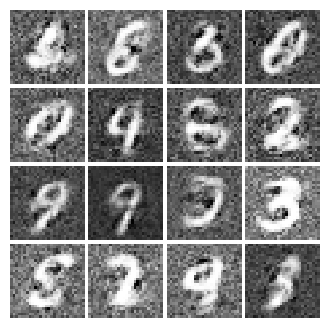


Iter: 2500, D: 0.1173, G:0.3574


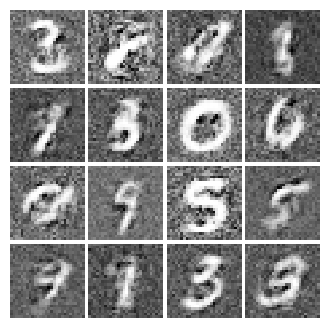


Iter: 2750, D: 0.09844, G:0.3732


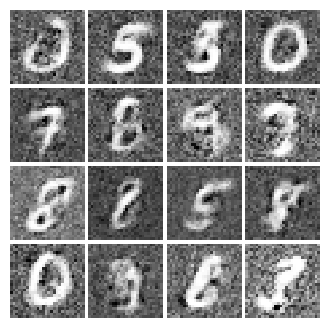


Iter: 3000, D: 0.09475, G:0.4651


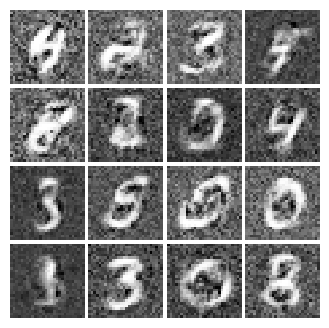


Iter: 3250, D: 0.09855, G:0.3827


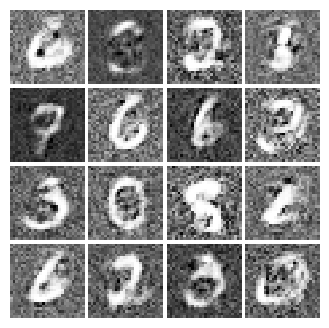


Iter: 3500, D: 0.09841, G:0.3953


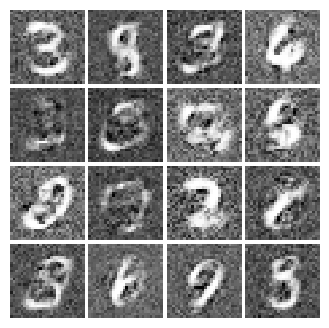


Iter: 3750, D: 0.1036, G:0.5339


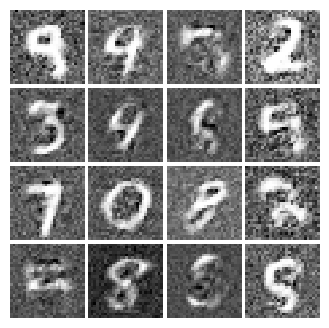


Iter: 4000, D: 0.1005, G:0.3339


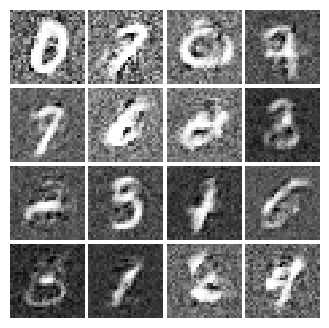


Iter: 4250, D: 0.104, G:0.4656


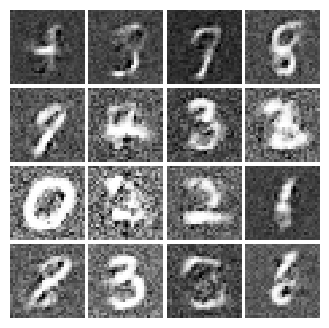


Iter: 4500, D: 0.09283, G:0.4194


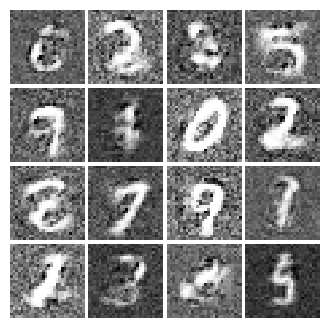

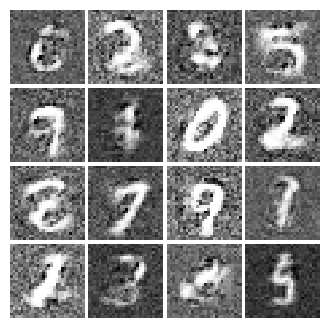

In [17]:
reset_seed(0)

D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss, 'ls_gan_results.jpg')